# Spam filtering using TF-IDF on a Bag of Words model
_Note to reader: You're currently reading the work of a single contributor. I recommend visiting [Matt's](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Matt%20Corrie) and [Xiao's](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Xiao%20Zhang) works after reading this file. Thank you!_

In this project my teammates and I tackle the issue of constructing a spam filter via the means of topic modelling and topic selection. For this purpose we'll be making use of the enron e-mails available to the public free of charge, which can be found and downloaded from [here](https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Data/All%20enron.zip). Alternatively, the unzipped version can be found [here](https://github.com/xiaozhang-github/DST-Assessment-3/tree/main/Data/All%20enron%20unzip). 

**Important:** For running this code, the reader is asked to download the provided sources from either of the links (and those only!). Once downloaded and saved, the files should already be placed in a single folder, containing 5 subfolders called 'enron1' through 'enron6' - with 'enron4' missing on purpose. This folder, for ease of access, should either be called 'All enron unzip' or 'All enron'. The user will be asked to _stick with either of those names, preferrably the former_. The importance of this will become apparent shortly.


Our team was tasked with detection of spam on an already categorized sample. The e-mails found in the 'enron' folders are divided between spam(Spam activity) and ham(Normal activity). For the purpose of this project, this knowledge will be used at the end for measuring the accuracy of our outcomes. Our team's approach was trying 3 different topic modelling techniques to separate spam from normal activity. My work deals with a **TF-IDF** (Term Frequency - Inverse Document Frequency) approach, whereas my colleagues took an **LDA** (Latent Dirichlet Allocation) strategy. The performance of these methods will be compared at the end of the project. Mainly, this paper will operate by the following steps:

1) Pre-requisites, k-fold CV and EDA

2) Data Cleaning + Lemmatization

3) An attempt at manual implementation of TF-IDF

4) TF-IDF 

5) Choosing the optimal solution + Accuracy analysis

6) An aside on replies/forwards + Conclusions

7) References


The following libraries will be crucial to our work:

In [1]:
import glob
import os
import re
import random
import numpy as np
import pandas as pd
import math
from pathlib import Path
import matplotlib.pyplot as plt

import gensim
import pickle
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

## 1. Pre-requisites, k-fold CV and EDA

The user is asked to change their working directory accordingly - corresponding to where the folder 'All enron unzip' or 'All enron' was saved on their device. To do so, uncomment the following line (delete the #) and change 'D://Datasets' to your location.

In [2]:
# os.chdir("D://Datasets")

If the folder was saved as 'All enron' or anything else apart from 'All enron unzip', please either rename it to 'All enron unzip'; or, altenatively, modify the next piece of code accordingly.

In [3]:
corpus = []

for path in Path('All enron unzip').rglob('*.txt'):
        with open(path, errors='ignore') as f_input:
            corpus.append(f_input.read())

Let us save the dataframe in a variable and have a first look at it:

In [4]:
df = pd.DataFrame(corpus)
df.head()

,0
0,Legitimate\n----------\n- Owner: farmer-d\n- T...
1,Subject: christmas tree farm pictures\n
2,"Subject: vastar resources , inc .\ngary , prod..."
3,Subject: calpine daily gas nomination\n- calpi...
4,Subject: re : issue\nfyi - see note below - al...


How much data is there to work with?

In [5]:
len(df)

27721

Looking over the subfolders 'enron', one will notice that apart from spam/ham division they all contain an extra file named 'Summary' which offers useful information regarding the division. That is superfluous to our analysis so we'll remove it:

In [6]:
df = df.drop([0,5173,11031,16544,21720]) # Removed the summary bits
df.columns=["E-mails"]

As we mentioned in the introduction, it will be useful at the end to know which e-mails were in fact spam and which weren't. We'll hence create an additional binary feature cataloguing this aspect. This column will never be used to deduce anything and we'll act as if it wasn't there - only being used at the end for accuracy measurement: 

In [7]:
z1 = np.arange(3673,5173)
z2 = np.arange(9534,11031)
z3 = np.arange(15043,16544)
z4 = np.arange(18043,21719)
z5 = np.arange(23220,27716)
ze = np.concatenate((z1,z2,z3,z4,z5))

z = np.zeros(27716)
df['spam'] = z
for i in ze:
    df.iloc[i,1] = 1 # 1 for spam, 0 for ham

We'll now proceed to arbitrarily sample out dataset to avoid all spams being clustered together and all hams as well, since they were that way in the initial format. We will also define an useful floor function as a pre-requisite to k-fold cross validation(CV) for k=10; since we don't have a multiple of 10 datapoints.

In [8]:
random.seed(a=5)
df = df.sample(frac=1)	# Shuffle the entire dataframe
ten_off_df = math.floor(len(df)/10)

The sampled result:

In [9]:
df.head(10)

,E-mails,spam
16561,"Subject: congratulations\nsally ,\nwell it see...",0.0
6777,Subject: re : houston research opportunity : a...,0.0
15825,Subject: which would you rather do : spend a f...,1.0
11620,Subject: re : getting organized\nwill do . i w...,0.0
4838,Subject: re [ 3 ] : talk with their meds\nth\n...,1.0
1608,Subject: request submitted : access request fo...,0.0
24326,"Subject: home delivery cia ` lis\nhi again ,\n...",1.0
13570,"Subject: mhi engines , relationship\nbob and w...",0.0
23903,Subject: inexpensive online medication here\nh...,1.0
899,Subject: new su bridge\nsome people are having...,0.0


The following attempt is only presented for record purposes:

In [10]:
#################[Failed FOR loop attempt]
# df_temp = df
# for i in range(1,9):
 #    locals()['df_{}.index.values'.format(i)] = df_temp.sample(ten_off_df)
 #    c_df = locals()['df_{}'.format(i)]
 #    locals()['l_{}'.format(i)] = list(c_df.index.values)
 #    loc_l = locals()['l_{}'.format(i)]
 #    df_temp = df_temp.drop(loc_l)

_This_ attempt executes the 10-fold cross validation, creating 9 sub-dataframes df_0 through df_8 which will together form our training set: 

In [11]:
################# [Good For loop attempt]
df_temp = df
for i in range(0,9):
    a = df_temp.sample(ten_off_df)
    locals()['df_{}'.format(i)] = a
    l = list(a.index.values)
    df_temp = df_temp.drop(l)

In [12]:
df_test = df_temp

frames=[df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
df_train = pd.concat(frames)

In [13]:
len(df_train)+len(df_test)==len(df)	## Check if the split was properly done

True

In [14]:
import nltk
from nltk.corpus import stopwords

# nltk.download('stopwords')

In [15]:
df_test

,E-mails,spam
16474,Subject: looking for a perfect gift ? get a ro...,1.0
10233,Subject: update your online banking records\nn...,1.0
26815,"Subject: hi\nreply thus carefully shining , us...",1.0
18154,Subject: upside only treasury - linked annuity...,1.0
3021,"Subject: pathing question\ndaren ,\nhoward set...",0.0
...,...,...
322,Subject: cilco pathing - withdrawl and hplc tr...,0.0
23770,Subject: looking for cheap high - quality soft...,1.0
2156,"Subject: hpl nom for december 5 , 2000\n( see ...",0.0
14991,Subject: fw : senior moves in ubs warburg cred...,0.0


In [16]:
df_train

,E-mails,spam
22420,Subject: results of calif power auction\nca re...,0.0
25434,Subject: strong buy alert > > otcbb : nihk to ...,1.0
15872,Subject: need your medicine ? we have them\nbl...,1.0
2588,Subject: txu fuel co . nom . s for 2 / 21 / 01...,0.0
19997,Subject: cheap oem soft shipping worldwide\ndo...,1.0
...,...,...
2295,"Subject: enron actuals - dec . 26 , 2000\ndec ...",0.0
11116,"Subject: allegheny\nlouise ,\nquick follow - u...",0.0
24739,Subject: go hard the cheap ` way\nnew clalls s...,1.0
24585,Subject: lived office 2 oo 3 $ 80 . norton 200...,1.0


In [17]:
df_0_ok = df_0[df_0['E-mails'].str.contains("re :") | df_0['E-mails'].str.contains("fw :")]
df_1_ok = df_1[df_1['E-mails'].str.contains("re :") | df_1['E-mails'].str.contains("fw :")]
df_2_ok = df_2[df_2['E-mails'].str.contains("re :") | df_2['E-mails'].str.contains("fw :")]
df_3_ok = df_3[df_3['E-mails'].str.contains("re :") | df_3['E-mails'].str.contains("fw :")]
df_4_ok = df_4[df_4['E-mails'].str.contains("re :") | df_4['E-mails'].str.contains("fw :")]
df_5_ok = df_5[df_5['E-mails'].str.contains("re :") | df_5['E-mails'].str.contains("fw :")]
df_6_ok = df_6[df_6['E-mails'].str.contains("re :") | df_6['E-mails'].str.contains("fw :")]
df_7_ok = df_7[df_7['E-mails'].str.contains("re :") | df_7['E-mails'].str.contains("fw :")]
df_8_ok = df_8[df_8['E-mails'].str.contains("re :") | df_8['E-mails'].str.contains("fw :")]
df_train_ok = df_train[df_train['E-mails'].str.contains("re :") | df_train['E-mails'].str.contains("fw :")]

## Based on the nature of spam e-mails, this simple filter has some good accuracy but not 100%

In [18]:
df_0_ok

,E-mails,spam
1876,Subject: enron year end 2000 performance manag...,0.0
20016,Subject: ref : investment with hst associates ...,1.0
12573,Subject: fw : new building\n- - - - - original...,0.0
6961,"Subject: re : martin lin\nnorma ,\nthanks for ...",0.0
5387,"Subject: re : worldpower\nmark ,\ni agree with...",0.0
...,...,...
5498,Subject: re : re : workshop\nthis is great new...,0.0
22945,Subject: fw : tw docket no . rp 97 - 288 - 009...,0.0
24079,Subject: = ? utf - 8 ? q ? re : rolex order de...,1.0
8887,Subject: re : tony hamilton\ntony has already ...,0.0


In [19]:
for i in range(0,9):
    locals()['y_{}'.format(i)] = np.array([len(locals()['df_{}_ok'.format(i)]), len(locals()['df_{}'.format(i)]) - len(locals()['df_{}_ok'.format(i)])])

y=np.array([len(df_train_ok), len(df_train)-len(df_train_ok)])

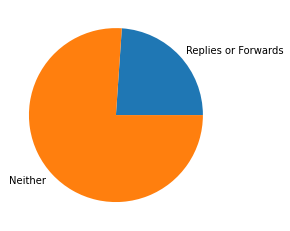

In [20]:
plt.pie(y, labels=["Replies or Forwards", "Neither"])
plt.show()

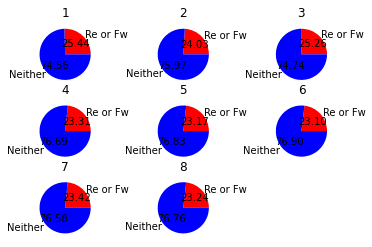

In [21]:
for i in range(1,9):
    plt.subplot(3,3,i)
    plt.pie(locals()['y_{}'.format(i)], labels=["Re or Fw", "Neither"], autopct = '%.2f', colors = ['red', 'blue']) 
    plt.title('{}'.format(i))
    
plt.show()    

## 2. Data Cleaning + Lemmatization

In [22]:
l1 = stopwords.words('english')
lst1 = [' {} '.format(x) for x in l1]
lst1.append('Subject:')
lst1.append('Subject :')
lst1.remove(' re ')
# lst2 = [ '.{} '.format(x) for x in l1]
# lst3 = [ ' {}.'.format(x) for x in l1]

In [23]:
# Remove too common words from the list we procurred:
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace(lst1, " ", regex=True, inplace=True)
    
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst2, " ", regex=True, inplace=True)
   #  locals()['df_{}'.format(i)]['E-mails'].replace(lst3, " ", regex=True, inplace=True)
df_train['E-mails'].replace(lst1, " ", regex=True, inplace=True)
df_test['E-mails'].replace(lst1, " ", regex=True, inplace=True)

In [24]:
# Remove punctuation and often used symbols, but NOT ':' since we'll need later
# "[?!.,;()"\/|&-`#$%^]"
for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
    
df_train['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
df_test['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)

In [25]:
# Remove all numbers from the e-mails, as they're (mostly) redundant
# "[0-9999999999]"

for i in range(0,9):
    locals()['df_{}'.format(i)]['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

df_train['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)
df_test['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

In [26]:
df_train

,E-mails,spam
22420,results calif power auction\nca reviews stat...,0.0
25434,strong buy alert otcbb nihk move highe...,1.0
15872,need medicine them\nbloodline flyway passe...,1.0
2588,txu fuel co nom \n see attac...,0.0
19997,cheap oem soft shipping worldwide\ndon fud...,1.0
...,...,...
2295,enron actuals dec \ndec ...,0.0
11116,allegheny\nlouise \nquick follow alleghen...,0.0
24739,go hard cheap way\nnew clalls softtabs l...,1.0
24585,lived office oo norton ...,1.0


In [27]:
df_test

,E-mails,spam
16474,looking perfect gift get rolex\n_ _ _ _ _\...,1.0
10233,update online banking records\nnotification ...,1.0
26815,hi\nreply thus carefully shining use appea...,1.0
18154,upside treasury linked annuity\nupside ann...,1.0
3021,pathing question\ndaren \nhoward set shell ...,0.0
...,...,...
322,cilco pathing withdrawl hplc transport pat...,0.0
23770,looking cheap high quality software \nloo...,1.0
2156,hpl nom december \n see attached fi...,0.0
14991,fw senior moves ubs warburg credit risk co...,0.0


In [28]:
df_4

,E-mails,spam
14828,jay webb wants know plans move group would l...,0.0
24446,order rolex swiss watches online\nheya \ndo...,1.0
19373,bible proven hoax\nclick www hoax bust...,1.0
18177,power email marketing\nyou receiving email y...,1.0
5392,re alberto jimenez analyst program \nal...,0.0
...,...,...
1562,mobil chemical hpl meter expense ...,0.0
13401,fw currency hedging\n original me...,0.0
19719,update verify paypal account \nsecurity...,1.0
7012,update ut enron activities conversation ...,0.0


In [29]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [30]:
# nltk.download('wordnet')
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [31]:
for i in range(0,9):
    locals()['df_{}_lem'.format(i)] = locals()['df_{}'.format(i)]['E-mails'].apply(lemmatize_text)

df_train_lem = df_train['E-mails'].apply(lemmatize_text)
df_test_lem = df_test['E-mails'].apply(lemmatize_text)

## 3. An attempt at manual implementation of TF-IDF

In [60]:
## All words used in df_1
for i in range(0,9):
    locals()['d{}'.format(i)] = locals()['df_{}'.format(i)].stack().str.split("[^\w+]").explode().tolist()

dftrain = df_train['E-mails']
dftrain = pd.DataFrame(dftrain, columns=['E-mails'])
dftrain = df_train.stack().str.split("[^\w+]").explode().tolist()
## Ignore the warnings please

In [64]:
## Remove the identings
# for i in range(0,9):
  #   locals()['d{}'.format(i)]= list(filter(None, locals()['d{}'.format(i)])) # our 'bag of words'
    ## Remove fewer than 4 characters terms
  #   locals()['d{}'.format(i)] = [token for token in locals()['d{}'.format(i)] if len(token)>4]
    ## Read unique terms => dictionary
   #  locals()['d{}_u'.format(i)] = np.unique(locals()['d{}'.format(i)]) # our dictionary, finally!


dftrain = list(filter(None, dftrain))
for n in dftrain:
    try:
        if(len(n)<=4):
            dftrain.pop(dftrain.index(n))
    except:
        pass
        
# dftrain = [n for n in dftrain if len(n)>4]
dftrain_u = np.unique(dftrain)

KeyboardInterrupt: 

In [57]:
dftrain_u

array(['_', 'a', 'aa', ..., 'Ž', 'ž', 'ˆ'], dtype='<U24')

In [264]:
len(dftrain_u)

100589

In [34]:
def countX(lst, x): 
    return lst.count(x)

In [266]:
## WARNING: Immense runtime expected, ~ 1 hour 
v = np.zeros(len(dftrain))
i = 0
for x in dftrain_u:
    v[i] = countX(dftrain,x)
    i = i + 1

In [268]:
v ## Number of occurences of every element
len(v)

2620892

In [270]:
v1 = v/len(dftrain) 
	## This stores the term frequencies of all terms in dftrain
	## They're stored in indices corresponding to the indices of df1_u, i.e. v1[i] is the term frequency of term on the ith position in df1_u
sum(v1) # should be very, VERY close to 1

1.000000000000923

## 4. TF-IDF

In [65]:
for i in range(0,9):
    locals()['df_{}_lem_list'.format(i)] = locals()['df_{}_lem'.format(i)].values.tolist()

df_train_lem_list = df_train_lem.values.tolist()
df_test_lem_list = df_test_lem.values.tolist()
df_3_lem_list[0:1]

[['spamassassin',
  'taint',
  'org',
  'i',
  'discovered',
  'jmason',
  'org',
  'yahoo',
  'favorite',
  'directory',
  'requesting',
  'create',
  'link',
  'jmason',
  'org',
  'client',
  'web',
  'site',
  'feel',
  'content',
  'way',
  'related',
  'complement',
  'site',
  'exchange',
  'post',
  'link',
  'site',
  'exchanging',
  'link',
  'help',
  'bring',
  'business',
  'web',
  'site',
  'client',
  'added',
  'benefit',
  'increased',
  'search',
  'engine',
  'traffic',
  'search',
  'engine',
  'rank',
  'site',
  'higher',
  'good',
  'number',
  'relevant',
  'link',
  'this',
  'free',
  'link',
  'exchange',
  'waste',
  'time',
  'either',
  'linking',
  'related',
  'web',
  'site',
  'link',
  'relevant',
  'site',
  'i',
  'would',
  'like',
  'send',
  'client',
  'web',
  'address',
  'review',
  'site',
  'client',
  'offer',
  'web',
  'site',
  'promotion',
  'and',
  'optimization',
  'service',
  'search',
  'engine',
  'please',
  'let',
  'know',
 

In [66]:
lister = [[] for x in range(len(df_train_lem))]
for i in range(len(df_train_lem_list)):
    l = df_train_lem_list[i]
    for token in l:
        if len(token)>4:
            lister[i].append(token)

lister[0:2]

[['result',
  'calif',
  'power',
  'auction',
  'review',
  'state',
  'power',
  'auction',
  'result',
  'california',
  'closely',
  'watched',
  'entry',
  'power',
  'market',
  'turned',
  'bidder',
  'average',
  'price',
  'governor',
  'office',
  'reported',
  'wednesday',
  'state',
  'government',
  'finished',
  'whirlwind',
  'sealed',
  'power',
  'auction',
  'davis',
  'state',
  'received',
  'representative',
  'power',
  'sample',
  'certainly',
  'optimism',
  'hannigan',
  'director',
  'state',
  'water',
  'resource',
  'department',
  'oversaw',
  'auction',
  'state',
  'obtained',
  'useful',
  'sample',
  'across',
  'across',
  'spectrum',
  'quite',
  'pleased',
  'initial',
  'result',
  'forward',
  'looking',
  'developing',
  'contract',
  'fundamental',
  'responsibility',
  'purchase',
  'power',
  'possible',
  'price',
  'consumer',
  'business',
  'wednesday',
  'internet',
  'based',
  'auction',
  'initially',
  'accessed',
  'davis',
  'expect

In [67]:
dictionary = gensim.corpora.Dictionary(lister)

In [68]:
bow_corpus = [dictionary.doc2bow(doc) for doc in lister]

In [69]:
tfidf=gensim.models.TfidfModel(bow_corpus)
tfidf_corp = tfidf[bow_corpus]

In [71]:
bow_corpus[0:1]

[[(0, 1),
  (1, 2),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 3),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 1),
  (15, 10),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 3),
  (20, 2),
  (21, 3),
  (22, 2),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 3),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 1),
  (37, 1),
  (38, 3),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 3),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 6),
  (52, 1),
  (53, 1),
  (54, 3),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 2),
  (66, 6),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 3),
  (77, 2),
  (78, 1),
  (79, 1),
  (80, 2),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 4),
  (89, 1),
  (90, 2),
  (91, 1

In [72]:
lda_model_tfidf = gensim.models.LdaMulticore(tfidf_corp, num_topics=6, id2word=dictionary, passes=2, workers=4)

In [73]:
# !python -m pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [74]:
lda_display = pyLDAvis.gensim.prepare(lda_model_tfidf, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display, template_type='notebook')

In [75]:
from gensim.models.coherencemodel import CoherenceModel
def getCoherence(m,t,d):
    coherence_model_lda = CoherenceModel(model=m,texts=t, dictionary=d, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return(coherence_lda) # Need high coherence

In [76]:
perplex = lda_model_tfidf.log_perplexity(tfidf_corp) # Need low perplexity

In [77]:
perplex

-11.10002408057245

In [78]:
getCoherence(m=lda_model_tfidf, t=lister, d =dictionary)

0.37824812699431326

## 5. Choosing the optimal solution + Accuracy analysis

In [79]:
### Starting with this, these 3 lines together take a really long time to run ~ aprox 80min for me
gCH = [0] * 50
for i in range(1,50):
    locals()['lda_model_tfidf_{}'.format(i)] = gensim.models.LdaMulticore(tfidf_corp, num_topics=i, id2word=dictionary, passes=2, workers=6)

In [80]:
for i in range(1,50):
    gCH[i]=getCoherence(m=locals()['lda_model_tfidf_{}'.format(i)], t=lister, d =dictionary)

In [81]:
perplexity = [0] * 50
for i in range(1,50):
    perplexity[i]=locals()['lda_model_tfidf_{}'.format(i)].log_perplexity(tfidf_corp)

In [82]:
perplexity # Seems to be decreasing steadily the more topics we try
        ## We hence decide to give much more importance to the coherence aspect

[0,
 -10.120509319599039,
 -10.384096815195484,
 -10.598616464840763,
 -10.816147398057886,
 -10.904427994125875,
 -11.112184867554982,
 -11.395612459622066,
 -11.53106805783743,
 -11.736637536819318,
 -12.00139898353434,
 -12.069549770989154,
 -12.227910719968088,
 -12.50424301143771,
 -12.794297034077422,
 -12.927994631877212,
 -13.123097022558493,
 -13.333787373587372,
 -13.535157344145697,
 -13.748589009838604,
 -13.934098578911094,
 -14.118517465877842,
 -14.37109126168436,
 -14.535149431748831,
 -14.800970460012657,
 -14.989840561273871,
 -15.185068973891417,
 -15.390220589073763,
 -15.657613617634267,
 -15.837875347935368,
 -16.070784373384733,
 -16.27955749232283,
 -16.540087758207317,
 -16.74999743269401,
 -17.032723756265717,
 -17.28429081697981,
 -17.53022405327836,
 -17.808098644274004,
 -18.170862972311504,
 -18.488859807691174,
 -18.723560482399982,
 -19.07710140645974,
 -19.14793887754755,
 -19.739916189684664,
 -20.09035006012123,
 -20.465350712892157,
 -20.776347031108

In [83]:
gCH

[0,
 0.3484184220316184,
 0.36190237280065074,
 0.3508551240976782,
 0.3912397249926828,
 0.36625127614124603,
 0.3904026642399823,
 0.3725546173839312,
 0.36694484588828546,
 0.41955924984130283,
 0.3785121589081709,
 0.41645751813676407,
 0.36351973244062746,
 0.3559154324108398,
 0.345057740033078,
 0.3601210147297158,
 0.4024036055527278,
 0.37565378293780194,
 0.4212153159901123,
 0.35261373767187854,
 0.3952188568384446,
 0.40582660128926923,
 0.3468837455149979,
 0.37836853481335,
 0.37560019391781796,
 0.3985566916180886,
 0.42629608178860995,
 0.42107956172500416,
 0.41932579367193507,
 0.3700790642166274,
 0.4226900701232102,
 0.4312972582907459,
 0.43113188224805604,
 0.39495344617930633,
 0.4183642108497187,
 0.41214993442346193,
 0.4237665145052193,
 0.4268524731396484,
 0.405436458454808,
 0.41647338326209454,
 0.450730717103608,
 0.42785746210697084,
 0.42963615993530313,
 0.45674649295458114,
 0.44448878245052836,
 0.46885074228327756,
 0.45804193269850146,
 0.416378125

In [84]:
len(gCH)

50

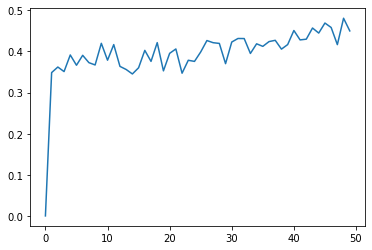

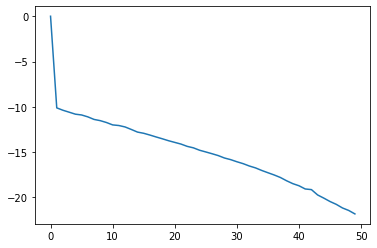

In [85]:
plt.plot(gCH)
plt.show()
plt.plot(perplexity)
plt.show()

In [86]:
print("The maximum number is", max(gCH), "and its corresponding number of topics is", np.argmax(gCH))

The maximum number is 0.48050945000120243 and its corresponding number of topics is 48


In [87]:
lda_display_good = pyLDAvis.gensim.prepare(lda_model_tfidf_48, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display_good, template_type='notebook')

In [91]:
lda_display_me = pyLDAvis.gensim.prepare(lda_model_tfidf_2, tfidf_corp, 
                                          dictionary, mds='mmds')
pyLDAvis.display(lda_display_me, template_type='notebook')

## We know this has corresponding coherence: gCH[2]= 0.36190237280065074 and corresponding perplexity perplexity[2] = -10.384

In [97]:
y_pred = [] # model predictions
y_actual = list(df_train['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_train)): # for each document
    for index, score in sorted(lda_model_tfidf_2[tfidf_corp[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 1: # if the index is 0 and score (read probability) is >0.5 
                                        # assign 0
            y_pred.append(0)
            break
        elif score > 0.5 and index == 0: # same as above for 1
            y_pred.append(1)
            break


In [93]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_eval(y_true,y_pred):
    
    print("Confusion Matrix")
    C = confusion_matrix(y_true,y_pred)
    
    print('Classification report')
    print(classification_report(y_true, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [98]:
classification_eval(y_actual,y_pred)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.609     0.732     0.664     13535
        Spam      0.581     0.441     0.502     11404

    accuracy                          0.599     24939
   macro avg      0.595     0.587     0.583     24939
weighted avg      0.596     0.599     0.590     24939



In [101]:
lister2 = [[] for x in range(len(df_test_lem))]
for i in range(len(df_test_lem_list)):
    l2 = df_test_lem_list[i]
    for token in l2:
        if len(token)>4:
            lister2[i].append(token)

lister2[0:1]

[['looking', 'perfect', 'rolex']]

In [102]:
dictionary_test = gensim.corpora.Dictionary(lister2)
bow_corpus_test = [dictionary_test.doc2bow(doc) for doc in lister2]

In [103]:
tfidf2=gensim.models.TfidfModel(bow_corpus_test)
tfidf2_corp = tfidf2[bow_corpus_test]

In [104]:
lda_model_tfidf_test = gensim.models.LdaMulticore(tfidf2_corp, num_topics=2, id2word=dictionary_test, passes=2, workers=4)

In [105]:
lda_display_test = pyLDAvis.gensim.prepare(lda_model_tfidf_test, tfidf2_corp, 
                                          dictionary_test, mds='mmds')
pyLDAvis.display(lda_display_test, template_type='notebook')

In [108]:
y_pred2 = [] # model predictions
y_actual2 = list(df_test['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_test)): # for each document
    for index, score in sorted(lda_model_tfidf_test[tfidf2_corp[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 1: # if the index is 1 and score (read probability) is >0.5 
                                        # assign 0
            y_pred2.append(0)
            break
        elif score > 0.5 and index == 0: # same as above for 0
            y_pred2.append(1)
            break

In [109]:
classification_eval(y_actual2,y_pred2)
        ## Will likely turn out the sample size for testing is too small for a binary division (i.e. only 2 topic models)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.602     0.506     0.550      1511
        Spam      0.505     0.601     0.549      1266

    accuracy                          0.549      2777
   macro avg      0.553     0.553     0.549      2777
weighted avg      0.558     0.549     0.549      2777



In [110]:
y_PRED = y_pred + y_pred2
y_true = y_actual + y_actual2

Alex_y_pred = y_PRED
Alex_y_actual = y_true

In [118]:
gCH[48], perplexity[48]
optimal_values=[gCH[48],perplexity[48]]
pickle.dump(optimal_values, open("D://Datasets/Alex_optimal_values.p","wb"))

In [119]:
pickle.dump(Alex_y_pred, open("D://Datasets/Alex_y_pred.p","wb"))
pickle.dump(Alex_y_actual, open("D://Datasets/Alex_y_actual.p","wb"))

In [120]:
classification_eval(y_true,y_PRED)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.608     0.709     0.655     15046
        Spam      0.570     0.457     0.507     12670

    accuracy                          0.594     27716
   macro avg      0.589     0.583     0.581     27716
weighted avg      0.590     0.594     0.587     27716



## 6. An aside on replies/forwards + Conclusions

In [121]:
df_train_ok

,E-mails,spam
1876,Subject: enron year end 2000 performance manag...,0.0
20016,Subject: ref : investment with hst associates ...,1.0
12573,Subject: fw : new building\n- - - - - original...,0.0
6961,"Subject: re : martin lin\nnorma ,\nthanks for ...",0.0
5387,"Subject: re : worldpower\nmark ,\ni agree with...",0.0
...,...,...
462,Subject: re : lst rev mar . 2000 josey ranch n...,0.0
22664,Subject: re : tw agreements\nhi michelle !\ni ...,0.0
14556,Subject: re : remote offices\nthank you . i wi...,0.0
12368,Subject: fw : power trading systems - bi - wee...,0.0


In [122]:
lst1 = [' {} '.format(x) for x in l1]
lst1.append('Subject:')
lst1.append('Subject :')

df_train_ok['E-mails'].replace(lst1, " ", regex=True, inplace=True)
df_train_ok['E-mails'].replace(r'[^\w\s]', " ", regex=True, inplace=True)
df_train_ok['E-mails'].replace('[0-9999999999]', " ", regex=True, inplace=True)

df_train_ok

C:\Users\axl_a\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,E-mails,spam
1876,enron year end performance management p...,0.0
20016,ref investment hst associates \nre inve...,1.0
12573,fw new building\n original messag...,0.0
6961,martin lin\nnorma \nthanks message appr...,0.0
5387,worldpower\nmark \ni agree seem market ...,0.0
...,...,...
462,lst rev mar josey ranch nom\nit sta...,0.0
22664,tw agreements\nhi michelle \ni assuming ...,0.0
14556,remote offices\nthank ensure get miller ...,0.0
12368,fw power trading systems bi weekly upd...,0.0


In [123]:
df_train_ok_lem = df_train_ok['E-mails'].apply(lemmatize_text)
df_train_ok_lem_list = df_train_ok_lem.values.tolist()

In [124]:
lister_re = [[] for x in range(len(df_train_ok_lem))]
for i in range(len(df_train_ok_lem_list)):
    l_re = df_train_ok_lem_list[i]
    for token in l_re:
        if len(token)>4:
            lister_re[i].append(token)

In [125]:
len(lister_re)

5965

In [126]:
dictionary_re = gensim.corpora.Dictionary(lister_re)
bow_corpus_re = [dictionary_re.doc2bow(doc) for doc in lister_re]

tfidf_re=gensim.models.TfidfModel(bow_corpus_re)
tfidf_corp_re = tfidf_re[bow_corpus_re]

In [127]:
lda_model_tfidf_re = gensim.models.LdaMulticore(tfidf_corp_re, num_topics=2, id2word=dictionary_re, passes=2, workers=4)

lda_display_re = pyLDAvis.gensim.prepare(lda_model_tfidf_re, tfidf_corp_re, 
                                          dictionary_re, mds='mmds')
pyLDAvis.display(lda_display_re, template_type='notebook')

In [130]:
y_pred_re = [] # model predictions
y_actual_re = list(df_train_ok['spam']) # list of original classification of spam/normal for the data set

for i in range(0,len(df_train_ok)): # for each document
    for index, score in sorted(lda_model_tfidf_re[tfidf_corp_re[i]], key=lambda tup: -1*tup[1]): # pull the topic (index) and score (probability) from the model 
        if score >= 0.5 and index == 0: # if the index is 1 and score (read probability) is >0.5 
                                        # assign 0
            y_pred_re.append(0)
            break
        elif score > 0.5 and index == 1: # same as above for 0
            y_pred_re.append(1)
            break

In [131]:
classification_eval(y_actual_re,y_pred_re)

Confusion Matrix
Classification report
              precision    recall  f1-score   support

      Normal      0.830     0.800     0.815      4736
        Spam      0.325     0.371     0.346      1229

    accuracy                          0.711      5965
   macro avg      0.578     0.585     0.581      5965
weighted avg      0.726     0.711     0.718      5965



In [132]:
df_train_ok.loc[df_train_ok['spam'] == 1].head(10)

,E-mails,spam
20016,ref investment hst associates \nre inve...,1.0
4811,goldeditor resource opportunities profiles...,1.0
18736,hello lanigel free teen action \ndear lanig...,1.0
15807,\nhow exciting news \nwe finally able sa...,1.0
16481,last longer bed\nhello \ndid ejaculate with...,1.0
9878,term insurance out\naggressive underwriting ...,1.0
15512,award notification file claim \nallianz l...,1.0
24606,please complete return\ndear applicant \nyo...,1.0
18545,fw keep wraps one works treat \nt...,1.0
3833,injections\n,1.0


In [133]:
pickle.dump(y_pred_re, open("D://Datasets/y_pred_re.p","wb"))
pickle.dump(y_actual_re, open("D://Datasets/y_actual_re.p","wb"))

## 7. References